## Cats and dog recognition using pytorch

### data loading and import

In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms
from torchvision import models
from torchvision.io import read_image
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import os

<p>device set up, using gpu or cpu</p>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
train_path = 'train/train/'
image_file_path = np.array([train_path + i for i in os.listdir(train_path)])
labels = np.array([
    0 if name.split('/')[-1].startswith('cat') else 1
    for name in image_file_path
])
print(len(image_file_path),len(labels))

25000 25000


In [3]:
# show result
image_file_path[:10], labels[:10]

(array(['train/train/cat.0.jpg', 'train/train/cat.1.jpg',
        'train/train/cat.10.jpg', 'train/train/cat.100.jpg',
        'train/train/cat.1000.jpg', 'train/train/cat.10000.jpg',
        'train/train/cat.10001.jpg', 'train/train/cat.10002.jpg',
        'train/train/cat.10003.jpg', 'train/train/cat.10004.jpg'],
       dtype='<U25'),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [4]:
from sklearn.model_selection import train_test_split
X_train, x_val, y_train, y_val = train_test_split(image_file_path, labels, test_size=0.9, random_state=42)

In [5]:
print(len(X_train))

2500


In [6]:
# Define how to load a dataset
class MyData(Dataset):
    def __init__(self, data_path, labels=None, transform=None):
        self.data_path = data_path
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image = read_image(self.filepath[index]) # [channel,height,width]
        image = image.to(torch.float32) / 255.
        if self.transform is not None:
            image = self.transform(image)
        if self.labels is not None:
            return image, self.labels[index]
        return image

    def __len__(self):
        return self.filepath.shape[0]

In [7]:
image_size = [224, 224]
batch_size = 32

<p> Transform without any data augmentation </p>

In [8]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

<p>Load image</p>

In [9]:
ds1 = MyData(X_train, y_train, transform)
ds2 = MyData(x_val, y_val, transform)


train_ds = DataLoader(ds1, batch_size=batch_size, shuffle=True)
val_ds = DataLoader(ds2, batch_size=batch_size, shuffle=True)

### model definition, we are defining all model layer

<p> Test of different self made model architecture</p>

In [5]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def flatten(x):
    return x.view(x.shape[0], -1)

In [6]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
    nn.AdaptiveAvgPool2d(1),
    Lambda(flatten),
    nn.Linear(32, 2)
)

In [13]:
optimizer = Adam(model.parameters(), lr=0.01)
loss_fun = F.cross_entropy

<p> train and evaluation fonction for pytorch model </p>

In [14]:
def train(model, epoch, train_ds):
    model.train()
    total_num = len(train_ds.dataset)
    train_loss = 0
    correct_num = 0
    batchcount=0
    for image, label in train_ds:
        # load data on the device (gpu or cpu)
        image = image.to(device)
        label = label.to(device)
        label = label.to(torch.long)
        #get the model prediction
        output = model(image)
        #calculate the loss
        loss = loss_fun(output, label)
        train_loss += loss.item() * label.size(0)
        optimizer.zero_grad()
        loss.backward()
        # use the optimizer to train
        optimizer.step()
        
        predict = torch.argmax(output, dim=-1)
        correct_num += label.eq(predict).sum()
        batchcount+=1
        print(batchcount)

    train_loss = train_loss / total_num
    train_acc = correct_num / total_num
    print('epoch: {} --> train_loss: {:.6f} - train_acc: {:.6f} - '.format(
        epoch, train_loss, train_acc), end='')

def evaluate(model, eval_ds, mode='val'):
    #evaluation fonction
    model.eval()

    total_num = len(eval_ds.dataset)
    eval_loss = 0
    correct_num = 0

    for image, label in eval_ds:
        image = image.to(device)
        label = label.to(device)
        label = label.to(torch.long)
        # get the prediction
        output = model(image)
        loss = loss_fun(output, label)
        eval_loss += loss.item() * label.size(0)
        # calculate the accuracy
        predict = torch.argmax(output, dim=-1)
        #number of good response
        correct_num += label.eq(predict).sum()
    
    eval_loss = eval_loss / total_num
    eval_acc = correct_num / total_num
    
    print('{}_loss: {:.6f} - {}_acc: {:.6f}'.format(
        mode, eval_loss, mode, eval_acc))

In [176]:
net=nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=3),
    nn.AdaptiveAvgPool2d(1),
    nn.ReLU(),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=3),
    nn.AdaptiveAvgPool2d(1),
    nn.ReLU(),
    Lambda(flatten),
    nn.Linear(20, 2),

)

In [206]:
for epoch in range(5):
    train(model, epoch, train_ds)
    evaluate(model, val_ds)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
epoch: 0 --> train_loss: 0.689752 - train_acc: 0.556800 - val_loss: 0.685379 - val_acc: 0.566971
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27

KeyboardInterrupt: 

In [180]:
# different network
net = net.to(device)
for epoch in range(5):
    train(net, epoch, train_ds)
    evaluate(net, val_ds)

IndexError: index 14748 is out of bounds for axis 0 with size 7500

### using resnet as base model

<p> we will now use resnet pretrained model as a base line for our model and fine tune it by changing the output layer weight </p>

In [23]:
model_resnet=models.resnet50(pretrained=True)
print(model_resnet)
print(model_resnet.fc.in_features) #print the dimension of the output layer of resnet


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# change the resnet model output layer
model = models.resnet50(pretrained=True)
in_features = model.fc.in_features  # Gets the input dimension of the top output layer
model.fc = nn.Linear(in_features, 2)  # Replace the output layer with the one you need, and the output dimension is 2
model.add_module('softmax', nn.Softmax(dim=-1)) # add a softmax layer
model=model.to(device)

In [20]:
print(model_resnet)

NameError: name 'model_resnet' is not defined

In [21]:
# Freeze the parameters of other layers except the top layer
for name, m in model.named_parameters():
    if name.split('.')[0] != 'fc':
        m.requires_grad_(False)

In [22]:
optimizer = Adam(model.parameters(), lr=0.01)
loss_fun = F.cross_entropy

In [24]:
for epoch in range(1):
    train(model, epoch, train_ds)
    evaluate(model, val_ds)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
epoch: 0 --> train_loss: 0.318992 - train_acc: 0.917600 - 

KeyboardInterrupt: 

In [25]:
import pickle

In [26]:
pickle.dump( model, open( "model_v1.pkl", "wb" ) )

### Final model architecture choice 

In [ ]:
# expliquer quel model nous testons pour les changements de lr et test data augmentation etc

### Different Data augmentation test

In [ ]:
# add different type of flip/crop/etc
#print different validation acc result 

In [ ]:
#random crop

In [53]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomCrop(200, padding=4),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

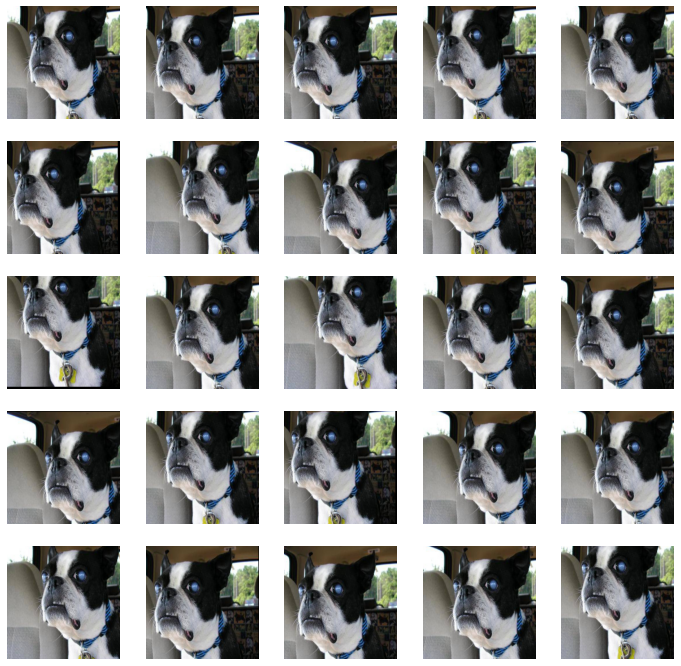

In [54]:
#view transform effect on picture

image = read_image(X_train[1])
image = image.to(torch.float32) / 255.
image = image.unsqueeze(0)

plt.figure(figsize=(12,12))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
for i in range(25):
    plt.subplot(5,5,i+1)
    img = transform(image)
    img = img[0,:,:,:].data.numpy().transpose([1,2,0])
    img = std * img + mean   # Anti Normalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
# horinzontal flip

In [55]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

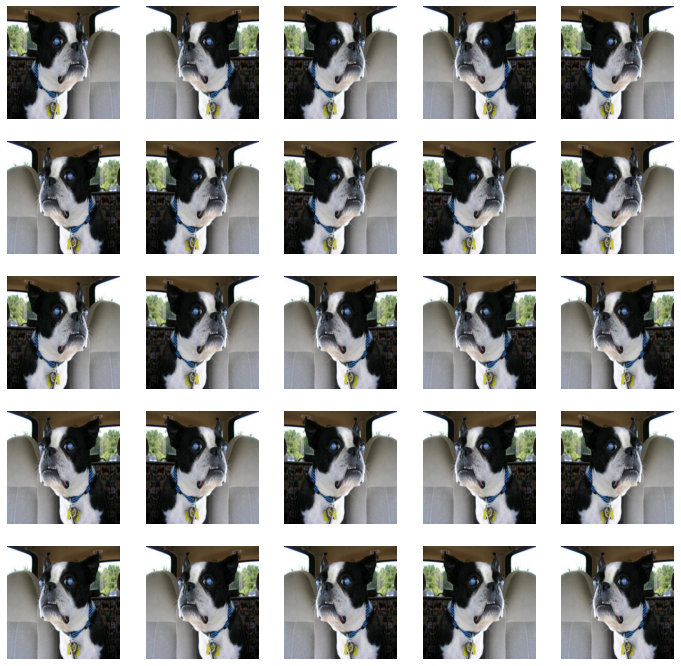

In [56]:
#view transform effect on picture

image = read_image(X_train[1])
image = image.to(torch.float32) / 255.
image = image.unsqueeze(0)

plt.figure(figsize=(12,12))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
for i in range(25):
    plt.subplot(5,5,i+1)
    img = transform(image)
    img = img[0,:,:,:].data.numpy().transpose([1,2,0])
    img = std * img + mean   # Anti Normalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [59]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomPerspective(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

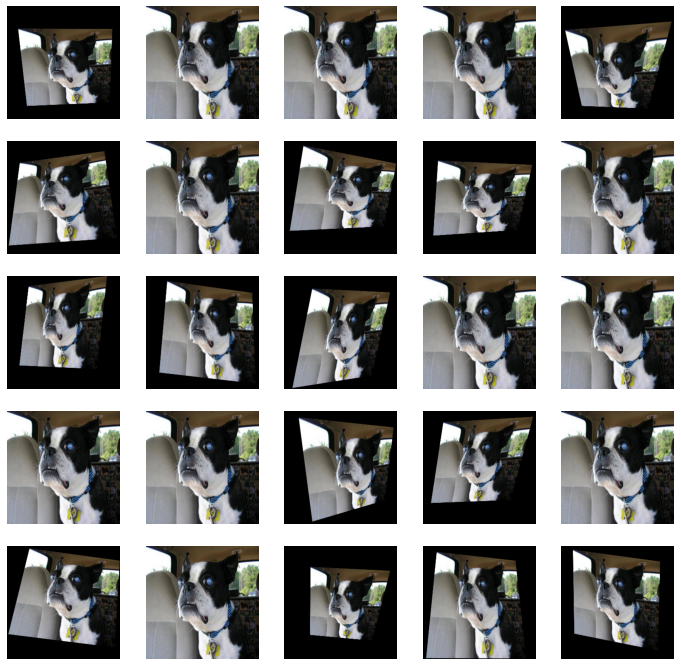

In [60]:
#view transform effect on picture

image = read_image(X_train[1])
image = image.to(torch.float32) / 255.
image = image.unsqueeze(0)

plt.figure(figsize=(12,12))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
for i in range(25):
    plt.subplot(5,5,i+1)
    img = transform(image)
    img = img[0,:,:,:].data.numpy().transpose([1,2,0])
    img = std * img + mean   # Anti Normalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [69]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomRotation(90),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

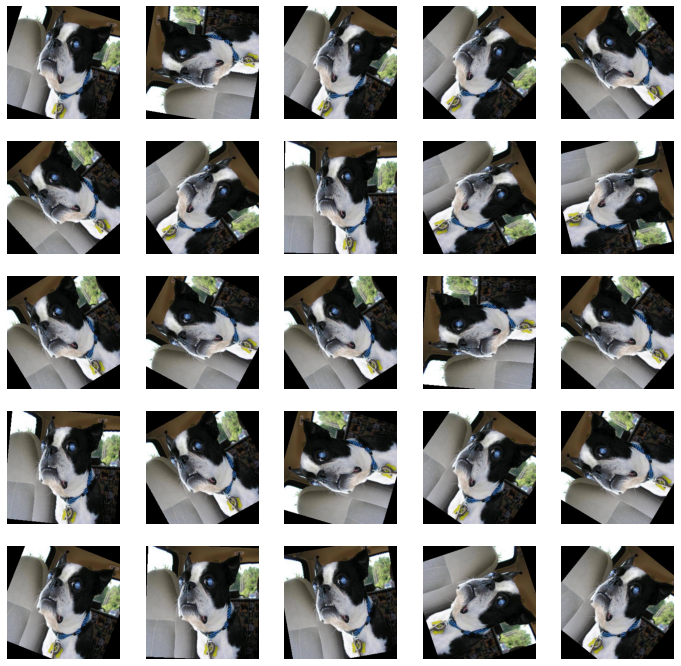

In [70]:
#view transform effect on picture

image = read_image(X_train[1])
image = image.to(torch.float32) / 255.
image = image.unsqueeze(0)

plt.figure(figsize=(12,12))
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
for i in range(25):
    plt.subplot(5,5,i+1)
    img = transform(image)
    img = img[0,:,:,:].data.numpy().transpose([1,2,0])
    img = std * img + mean   # Anti Normalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()